Checking required packages...
Please select the data folder window...
Selected Directory: D:/python_workplace/ESP32_autonomous_driving/training_data
Original data count: 2161
Filtered data count (removed backward): 2160
Loading images and syncing labels...


100%|█████████████████████████████████████████████████████████████████████████████| 2160/2160 [00:05<00:00, 398.22it/s]


Final loaded tensors shape: (2160, 120, 160, 3)
Final loaded targets shape: (2160,)


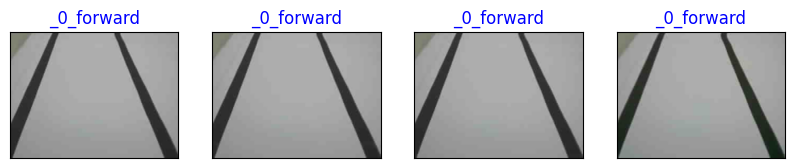

Train shapes: (1728, 120, 160, 3), (1728, 4)
Test shapes: (216, 120, 160, 3), (216, 4)
Valid shapes: (216, 120, 160, 3), (216, 4)
Building Optimized MobileNetV2 Model...
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 160, 3)]     0         
                                                                 
 model (Functional)          (None, 4, 5, 1280)        2257984   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 100)               128100    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                     

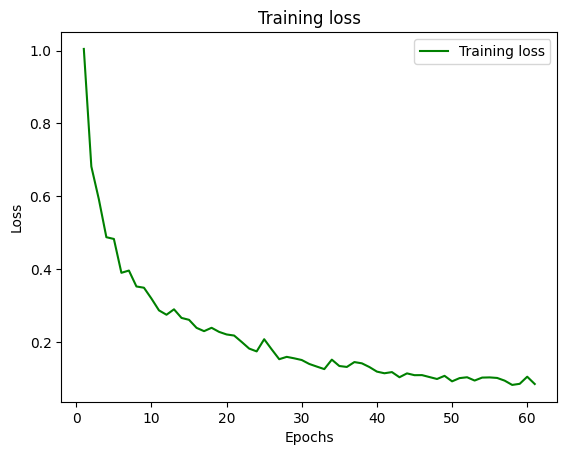

Model saved to model_MN_20251226114022.h5
Evaluating model...
Loaded generated model successfully: model_MN_20251226114022.h5
7/7 [==============================] - 1s 62ms/step


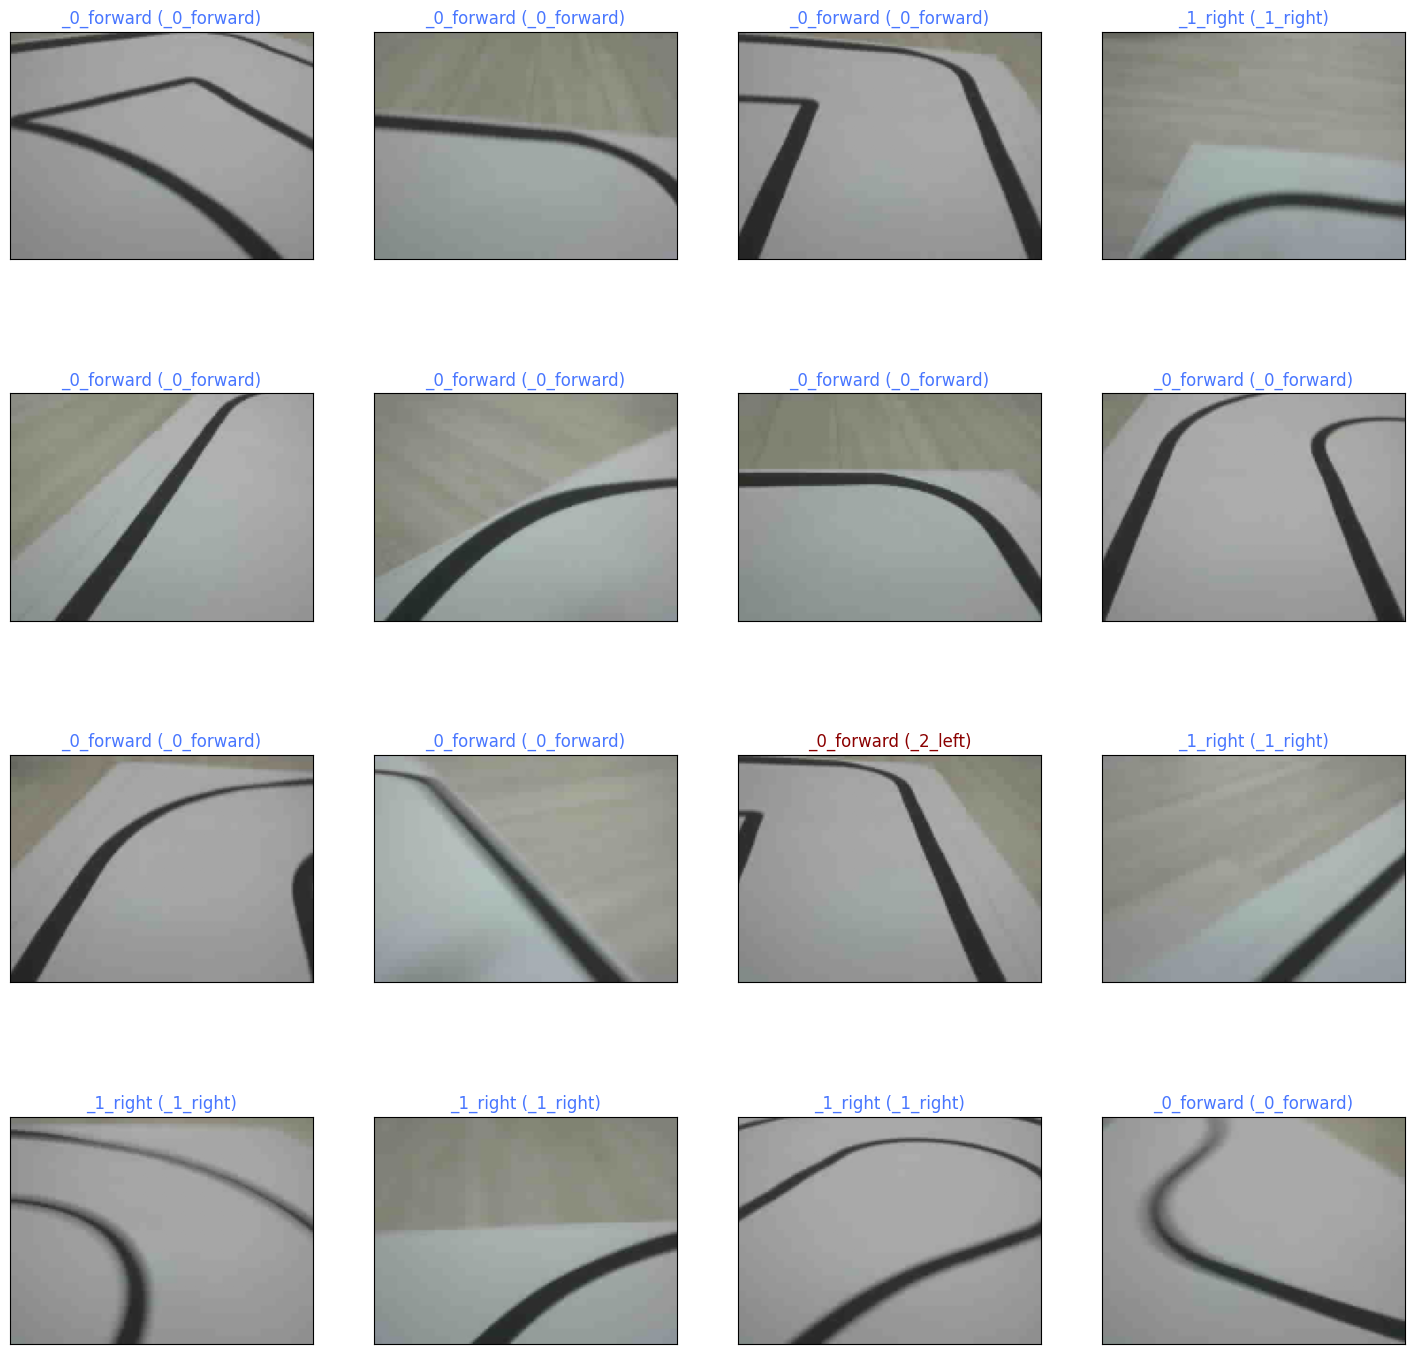

In [2]:
import sys
import subprocess
import importlib
import os
import tkinter as tk
from tkinter import filedialog
from datetime import datetime

# ---------------------------------------------------------
# 1. 패키지 자동 설치 함수
# ---------------------------------------------------------
def install_package(module_name, package_name=None):
    if package_name is None:
        package_name = module_name
    try:
        importlib.import_module(module_name)
    except ImportError:
        print(f"Installing {package_name} ...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            print(f"{package_name} installation completed")
        except subprocess.CalledProcessError as e:
            print(f"{package_name} installation failed (exit code {e.returncode})")
            sys.exit(1)

# 필수 패키지 확인 및 설치
print("Checking required packages...")
install_package("tensorflow")
install_package("numpy")
install_package("pandas")
install_package("tqdm")
install_package("PIL", "Pillow")
install_package("cv2", "opencv-python")
install_package("matplotlib")
install_package("sklearn", "scikit-learn")

# ---------------------------------------------------------
# 2. 라이브러리 임포트
# ---------------------------------------------------------
from tensorflow.keras.preprocessing import image as keras_image
import numpy as np
from tqdm import tqdm
from PIL import ImageFile
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ---------------------------------------------------------
# 3. 데이터 로드 및 전처리
# ---------------------------------------------------------

print("Please select the data folder window...")
root = tk.Tk()
root.attributes('-topmost', True)
root.withdraw()                  
root.focus_force()               
dirname = filedialog.askdirectory(title='Select Data Folder to Train')
root.destroy()

if not dirname:
    print("No folder selected. Exiting...")
    sys.exit()

print(f"Selected Directory: {dirname}")

if not dirname.endswith('/'):
    dirname += '/'

def image_to_tensor(img_path):
    try:
        path = os.path.join(dirname, img_path)
        if not os.path.exists(path):
            print(f"File missing: {img_path}")
            return None
            
        img = keras_image.load_img(path, target_size=(120, 160))
        x = keras_image.img_to_array(img)
        # 중요: MobileNetV2는 0~255가 아니라 -1~1 사이의 입력을 기대합니다.
        x = preprocess_input(x) 
        return np.expand_dims(x, axis=0)
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None

ImageFile.LOAD_TRUNCATED_IMAGES = True

# CSV 로드
csv_path = os.path.join(dirname, "0_road_labels.csv")
if not os.path.exists(csv_path):
    print(f"Error: CSV file '{csv_path}' not found in the selected folder.")
    sys.exit()

data = pd.read_csv(csv_path)

# 후진 데이터(Label 4) 제거
print(f"Original data count: {len(data)}")
data = data[data['label'] != 4]
print(f"Filtered data count (removed backward): {len(data)}")

# 인덱스 초기화
data = data.reset_index(drop=True)

print("Loading images and syncing labels...")

valid_tensors = []
valid_labels = []

for index, row in tqdm(data.iterrows(), total=data.shape[0]):
    img_path = row['file']
    label = row['label']
    
    tensor = image_to_tensor(img_path)
    
    if tensor is not None:
        valid_tensors.append(tensor)
        valid_labels.append(label)

if len(valid_tensors) > 0:
    tensors = np.vstack(valid_tensors)
    targets = np.array(valid_labels)
else:
    print("Error: No valid images loaded.")
    sys.exit()

files = data['file'].values[:len(targets)] 

print(f"Final loaded tensors shape: {tensors.shape}")
print(f"Final loaded targets shape: {targets.shape}")

if tensors.shape[0] != targets.shape[0]:
    print("Error: Mismatch between images and labels.")
    sys.exit()

# ---------------------------------------------------------
# 4. 데이터 시각화
# ---------------------------------------------------------
names = ['_0_forward', '_1_right', '_2_left', '_3_stop']

def display_images(img_path, ax):
    img = cv2.imread(os.path.join(dirname, img_path))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

fig = plt.figure(figsize=(10, 3))
count = 0
for i in range(len(files)):
    if count >= 4: break
    ax = fig.add_subplot(1, 4, count + 1, xticks=[], yticks=[])
    ax.set_title(names[targets[i]], color='blue')
    display_images(files[i], ax)
    count += 1
plt.show()

# ---------------------------------------------------------
# 5. 데이터셋 분리
# ---------------------------------------------------------
tensors = tensors.reshape(-1, 120, 160, 3)
# 중요: 전처리는 위 image_to_tensor의 preprocess_input에서 이미 처리됨 (255나누기 생략)

targets = to_categorical(targets, 4)

x_train, x_test, y_train, y_test = train_test_split(
        tensors,
        targets,
        test_size = 0.2,
        random_state = 1)

n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]

print(f"Train shapes: {x_train.shape}, {y_train.shape}")
print(f"Test shapes: {x_test.shape}, {y_test.shape}")
print(f"Valid shapes: {x_valid.shape}, {y_valid.shape}")

# ---------------------------------------------------------
# 6. 모델 정의 (MobileNetV2 Optimized Transfer Learning)
# ---------------------------------------------------------
print("Building Optimized MobileNetV2 Model...")

# 1. Base Model 로드 (ImageNet 가중치)
base_model_full = MobileNetV2(weights='imagenet', include_top=False, input_shape=(120, 160, 3))

# 2. 레이어 절단: 너무 추상적인 마지막 층 대신 'out_relu' 지점에서 특징 추출
base_model = Model(inputs=base_model_full.input, 
                   outputs=base_model_full.get_layer('out_relu').output)

# 3. 미세 조정(Fine-Tuning) 설정: 뒷부분 20개 레이어만 학습 허용
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# 4. 헤드 구성 (100 -> 50 Dense 층)
inputs = Input(shape=(120, 160, 3))
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()

# 5. 컴파일: 미세 조정을 위해 학습률을 낮게 설정 (0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# ---------------------------------------------------------
# 7. 학습 실행
# ---------------------------------------------------------
class ReachTargetAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_acc):
        super(ReachTargetAccuracy, self).__init__()
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_acc = logs.get('val_accuracy')
        if val_acc is not None and val_acc >= self.target_acc:
            print(f"\n\n검증 정확도가 목표치({self.target_acc*100:.2f}%)에 도달했습니다: {val_acc*100:.4f}%")
            self.model.stop_training = True

# Patience 증가 (20 -> 30)
early_stop_loss = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-7)

TARGET_ACCURACY = 0.95
target_acc_callback = ReachTargetAccuracy(target_acc=TARGET_ACCURACY)

print("Starting training...")

callbacks_list = [early_stop_loss, target_acc_callback, reduce_lr]

# 데이터 증강 설정 (밝기 및 채널 이동으로 조명 변화 대응)
datagen = ImageDataGenerator(
    rotation_range=3,
    width_shift_range=0.1,
    height_shift_range=0.1,brightness_range=[0.9, 1.1]
)

print("Starting training with Optimized Settings...")
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    validation_data=(x_valid, y_valid),
    steps_per_epoch=len(x_train) // 32,
    epochs=100,
    callbacks=callbacks_list,
)

# 학습 곡선 시각화
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 모델 저장
current_time = datetime.now().strftime("%Y%m%d%H%M%S")
filename = f"model_MN_{current_time}.h5"

# .h5 포맷으로 저장
model.save(filename, save_format='h5')
print(f"Model saved to {filename}")

# ---------------------------------------------------------
# 8. 테스트 및 검증
# ---------------------------------------------------------
print("Evaluating model...")

try:
    if os.path.exists(filename):
        model1 = load_model(filename)
        print(f"Loaded generated model successfully: {filename}")
    else:
        print("Model file not found.")
        model1 = model
except Exception as e:
    print(f"Error loading model: {e}")
    model1 = model

y_test_predict = model1.predict(x_test)
y_test_predict = np.argmax(y_test_predict, axis=1)

# 테스트 데이터 시각화 (이미 preprocess_input이 적용된 상태이므로 시각화를 위해 역산 혹은 원본 사용 권장하나 여기서는 단순 출력)
sample_size = min(16, x_test.shape[0])
if sample_size > 0:
    fig = plt.figure(figsize=(18, 18))
    indices = np.random.choice(x_test.shape[0], size=sample_size, replace=False)
    for i, idx in enumerate(indices):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        # 시각화를 위해 -1~1 범위를 다시 0~1로 임시 변환하여 보여줌
        temp_img = (x_test[idx] + 1.0) / 2.0
        ax.imshow(np.clip(temp_img, 0, 1))
        
        pred_idx = y_test_predict[idx]
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(names[pred_idx], names[true_idx]),
            color=("#4876ff" if pred_idx == true_idx else "darkred"))
    plt.show()
else:
    print("Not enough test data to visualize.")